In [3]:
from typing import TypedDict , Annotated , Optional
from langgraph.graph import add_messages, StateGraph , END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from uuid import uuid4
import json
from langchain_groq import ChatGroq


load_dotenv()
# model = ChatGroq(model="llama-3.1-8b-instant")
model = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)


In [ ]:
search_tool = TavilySearchResults(max_results=4)


In [ ]:
tools=[search_tool]
memory = MemorySaver()

llm_with_tools = model.bind_tools(tools)



content='' additional_kwargs={'tool_calls': [{'id': 'call_eMGwbVwo271Qybmk6XamESHg', 'function': {'arguments': '{"query":"current weather in Chennai"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 86, 'total_tokens': 108, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_dbaca60df0', 'id': 'chatcmpl-BUoZvxgTn7tXrl38PK9erb85W1voC', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--a2b42c0b-2334-48ff-94c8-eabce0ad7dce-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Chennai'}, 'id': 'call_eMGwbVwo271Qybmk6XamESHg', 'type': 'tool_call'}] usage_metadata={'input_tokens': 86, 'output_toke

In [7]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

class State(TypedDict):
    messages: Annotated[list, add_messages]

async def model(state: State):
    result = await llm_with_tools.ainvoke(state["messages"])
    return {
        "messages": [result], 
    }

async def tools_router(state: State):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else: 
        return END
    
async def tool_node(state):
    """Custom tool node that handles tool calls from the LLM."""
    # Get the tool calls from the last message
    tool_calls = state["messages"][-1].tool_calls
    
    # Initialize list to store tool messages
    tool_messages = []
    
    # Process each tool call
    for tool_call in tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_id = tool_call["id"]
        
        # Handle the search tool
        if tool_name == "tavily_search_results_json":
            # Execute the search tool with the provided arguments
            search_results = await search_tool.ainvoke(tool_args)
            
            # Create a ToolMessage for this result
            tool_message = ToolMessage(
                content=str(search_results),
                tool_call_id=tool_id,
                name=tool_name
            )
            
            tool_messages.append(tool_message)
    
    # Add the tool messages to the state
    return {"messages": tool_messages}

graph_builder = StateGraph(State)

graph_builder.add_node("model", model)
graph_builder.add_node("tool_node", tool_node)
graph_builder.set_entry_point("model")

graph_builder.add_conditional_edges("model", tools_router)
graph_builder.add_edge("tool_node", "model")

graph = graph_builder.compile(checkpointer=memory)


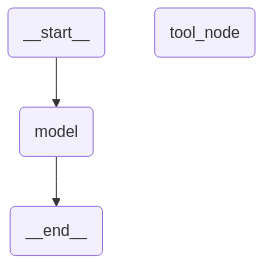

In [8]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [11]:
config = {
    "configurable": {
        "thread_id": 5
    }
}

response = await graph.ainvoke({
    "messages": [HumanMessage(content="When is the next langgraph conference?")], 
}, config=config)

response

{'messages': [HumanMessage(content='Hi i am Harish', additional_kwargs={}, response_metadata={}, id='aa45340c-2418-4ef2-a776-4b8203c56e03'),
  AIMessage(content='Hello Harish! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 84, 'total_tokens': 97, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_dbaca60df0', 'id': 'chatcmpl-BUof5FkWGhCELCzx7zATI7lZ3kR3V', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--88976497-dab1-4fac-8598-fe45f4ad5395-0', usage_metadata={'input_tokens': 84, 'output_tokens': 13, 'total_tokens': 97, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(

In [13]:
config = {
    "configurable": {
        "thread_id": 8
    }
}

# Use async for to iterate over the async generator
events=graph.astream_events({
    "messages": [HumanMessage(content="When is the next spacex launch?")],
}, config=config, version="v2")


async for event in events: 
    if event["event"] == "on_chat_model_stream":
        print(event["data"]["chunk"].content, end="", flush=True)

The next SpaceX launch is scheduled for **April 1, 2024**, at **7:30 PM PDT**. This will be a Falcon 9 rocket launch carrying the Starlink Group 7-18 mission from Vandenberg Space Force Station in California.

For more details, you can check the [SpaceX Launch Schedule](https://earthsky.org/spaceflight/spacex-starlink-launches-april-2024/).